In [0]:
from fastai.vision import * 

In [27]:
path = untar_data(URLs.MNIST)
path

PosixPath('/root/.fastai/data/mnist_png')

In [0]:
tfms = get_transforms(do_flip=False)
data = (ImageList
        .from_folder(path/"training")
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms=tfms)
        .databunch())

def get_one_channel(batch):
  x,y = batch
  return x[:,0,:,:].unsqueeze(1),y

data.add_tfm(get_one_channel)

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
def create_model(nfs,dp=None,**args):
  layers = []
  for i,o in nfs:
    conv = conv2(i,o)
    res = res_block(o)
    layers.append(conv)
    layers.append(res)
    if dp:
      d = dp(**args)
      layers.append(d)
  layers.append(Flatten())
  layers = nn.Sequential(*layers)
  return layers

In [0]:
nfs = [
    (1,8),
    (8,16),
    (16,32),
    (32,16),
    (16,10)
]

# dp = partial(nn.Dropout,inplace=True)
dp = None

model = create_model(nfs,dp,p=0.2)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


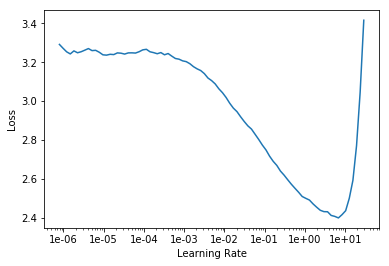

In [56]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.236746,0.171367,0.943083,01:24
1,0.165626,0.241431,0.932417,01:25
2,0.116794,0.097266,0.970750,01:23
3,0.102358,0.081387,0.976000,01:24
